In [1]:
import torch
import torchvision.datasets as datasets
import torchvision
from matplotlib import pyplot as plt
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import numpy as np
import warnings

c:\Users\HP\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\HP\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. MNIST Classification using RNN

In [2]:
#Loading the data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

#Splitting the data into train and validation sets.
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

In [3]:
#Initializing batch_size and epoch number
batch_size = 100
n_iters = 8000
num_epochs = 15

In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True)

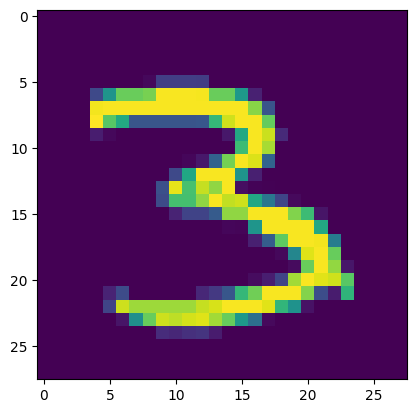

In [5]:
#Visualizing the input
plt.imshow(train_data[1][0].reshape((28,28)))
plt.show()

In [6]:
len(train_data), len(val_data), len(test_data)

(50000, 10000, 10000)

### Vanilla RNN cells

In [7]:
class Vanilla_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Vanilla_RNN,self).__init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim,layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        out,hn = self.rnn(x,h0)
        out = self.fc(out[:,-1,:])
        return out

In [8]:
#initializing model architecture parameters
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

In [9]:
#Loading the model
model = Vanilla_RNN(input_dim, hidden_dim, layer_dim, output_dim)
print(model)
#Using CrossEntropyLoss as loss function
error = nn.CrossEntropyLoss()
learning_rate = 0.001

#Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Vanilla_RNN(
  (rnn): RNN(28, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
#Training the model

seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_val = []
validation_error = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        # print(train.shape)
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                temp_loss = error(outputs, labels)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_val.append(accuracy)
            validation_error.append(temp_loss.data)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy.item()))
                #print(count, loss.data.item(), accuracy.item())

KeyboardInterrupt: 

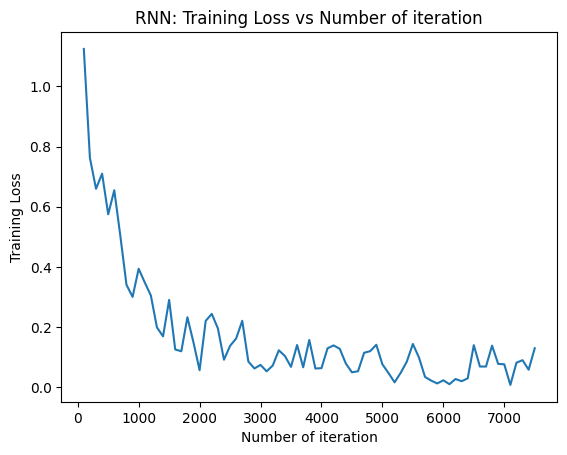

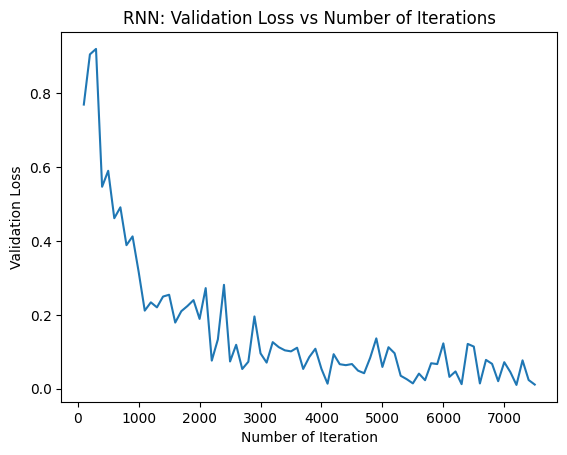

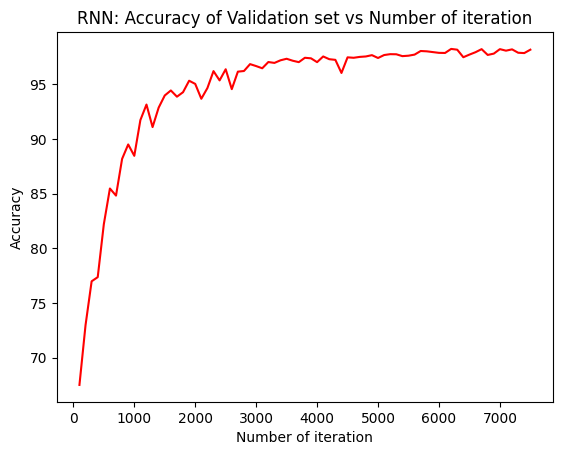

In [142]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Training Loss")
plt.title("RNN: Training Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list, validation_error)
plt.xlabel("Number of Iteration")
plt.ylabel("Validation Loss")
plt.title("RNN: Validation Loss vs Number of Iterations")
plt.show()
# visualization accuracy 
plt.plot(iteration_list,accuracy_val,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy of Validation set vs Number of iteration")
plt.savefig('graph.png')
plt.show()



Final accuracy in the test set is

In [144]:
correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader:
    images = Variable(images.view(-1, seq_dim, input_dim))
    
    # Forward propagation
    outputs = model(images)
    temp_loss = error(outputs, labels)
    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]
    
    # Total number of labels
    total += labels.size(0)
    
    correct += (predicted == labels).sum()

accuracy = 100 * correct / float(total)
print("Accuracy on test data using Vanilla RNN model is",accuracy.item(),"%")

Accuracy on test data using Vanilla RNN model is 97.98999786376953 %


### LSTM/GRU RNN cells


In [145]:
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        out, (hn, cn) = self.lstm(x,(h0, c0))
        out = self.fc(out[:,-1,:])
        return out

In [146]:
#Initializing the model parameters
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

In [147]:
#Creating an instance of the model.
model = LSTM_Model(input_dim, hidden_dim, layer_dim, output_dim)

#Using SGD optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

#Using CrossEntropyLoss as loss function
criterion = nn.CrossEntropyLoss()


In [150]:
#Training the model
seq_dim = 28  
num_epochs = 15

iter = 0
loss_list = []
iteration_list = []
accuracy_val = []
validation_error = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        #print(images[:,-1,:].shape)
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                temp_loss = error(outputs, labels)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(iter)
            accuracy_val.append(accuracy)
            validation_error.append(temp_loss.data)
            if iter % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iter, loss.data.item(), accuracy.item()))

Iteration: 500  Loss: 2.27048397064209  Accuracy: 19.15999984741211 %
Iteration: 1000  Loss: 1.044560194015503  Accuracy: 57.5099983215332 %
Iteration: 1500  Loss: 0.4421215355396271  Accuracy: 84.44000244140625 %
Iteration: 2000  Loss: 0.3194279968738556  Accuracy: 92.61000061035156 %
Iteration: 2500  Loss: 0.34517139196395874  Accuracy: 78.94999694824219 %
Iteration: 3000  Loss: 0.1857399046421051  Accuracy: 95.4800033569336 %
Iteration: 3500  Loss: 0.0907537043094635  Accuracy: 96.2699966430664 %
Iteration: 4000  Loss: 0.14211906492710114  Accuracy: 96.5999984741211 %
Iteration: 4500  Loss: 0.148213192820549  Accuracy: 96.61000061035156 %
Iteration: 5000  Loss: 0.11250684410333633  Accuracy: 96.88999938964844 %
Iteration: 5500  Loss: 0.07253719866275787  Accuracy: 97.33999633789062 %
Iteration: 6000  Loss: 0.06352037191390991  Accuracy: 97.6500015258789 %
Iteration: 6500  Loss: 0.07139065116643906  Accuracy: 97.51000213623047 %
Iteration: 7000  Loss: 0.030524183064699173  Accuracy: 

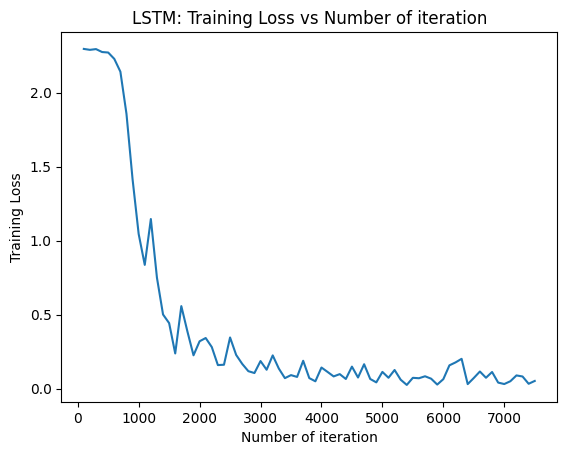

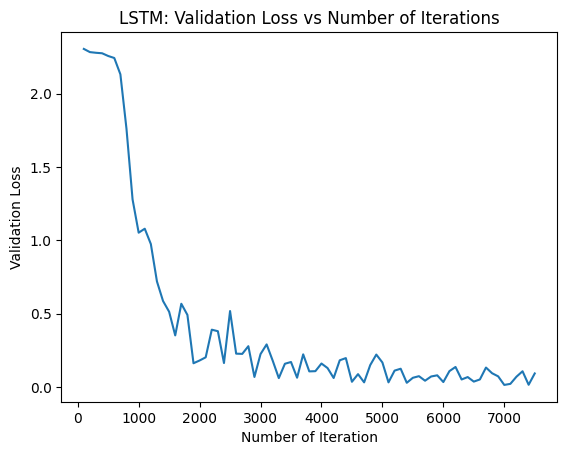

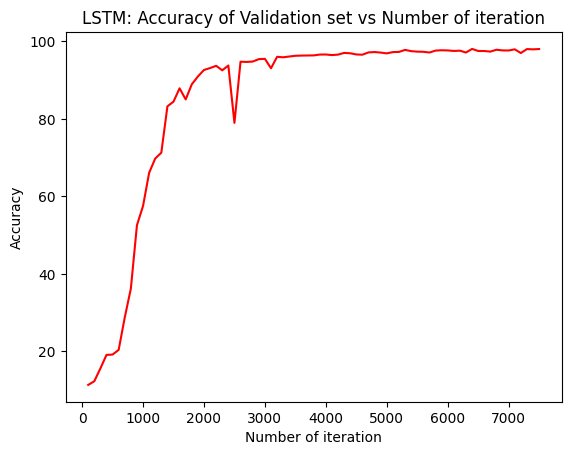

In [151]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Training Loss")
plt.title("LSTM: Training Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list, validation_error)
plt.xlabel("Number of Iteration")
plt.ylabel("Validation Loss")
plt.title("LSTM: Validation Loss vs Number of Iterations")
plt.show()
# visualization accuracy 
plt.plot(iteration_list,accuracy_val,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy of Validation set vs Number of iteration")
plt.savefig('graph.png')
plt.show()


In [213]:
correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader:
    images = Variable(images.view(-1, seq_dim, input_dim))
    
    # Forward propagation
    outputs = model(images)
    temp_loss = error(outputs, labels)
    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]
    
    # Total number of labels
    total += labels.size(0)
    
    correct += (predicted == labels).sum()

accuracy = 100 * correct / float(total)
print("Accuracy on test data using LSTM model is",accuracy.item(),"%")

Accuracy on test data using LSTM model is 97.79000091552734 %


### Using BiDirectional RNN/LSTM Network

In [205]:
class LSTM_Bi(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM_Bi, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)        
        self.layer = nn.Linear(hidden_size*2, output_size)            
            
    def forward(self, images):
        
        
        # Hidden state:
        hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
        # Cell state:
        cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images, (hidden_state, cell_state))
        output = output[:, -1, :]
        output = self.layer(output)
        
        return output

In [206]:
batch_size = 64
input_size = 28       # width of image
hidden_size = 128     # number of hidden neurons
layer_size = 2        # number of layers
output_size = 10      # possible choices

In [207]:
#Creating an instance of the model.
model = LSTM_Bi(input_dim, hidden_dim, layer_dim, output_dim)

#Using SGD optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

#Using CrossEntropyLoss as loss function
criterion = nn.CrossEntropyLoss()

In [208]:
#Training the model
seq_dim = 28  
num_epochs = 15

iter = 0
loss_list = []
iteration_list = []
accuracy_val = []
validation_error = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        #print(images[:,-1,:].shape)
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                temp_loss = error(outputs, labels)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(iter)
            accuracy_val.append(accuracy)
            validation_error.append(temp_loss.data)
            if iter % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iter, loss.data.item(), accuracy.item()))

Iteration: 500  Loss: 2.2951548099517822  Accuracy: 16.18000030517578 %
Iteration: 1000  Loss: 1.5015226602554321  Accuracy: 53.7599983215332 %
Iteration: 1500  Loss: 0.5762221217155457  Accuracy: 78.4800033569336 %
Iteration: 2000  Loss: 0.3335423171520233  Accuracy: 88.86000061035156 %
Iteration: 2500  Loss: 0.29667407274246216  Accuracy: 92.3499984741211 %
Iteration: 3000  Loss: 0.14931920170783997  Accuracy: 88.12000274658203 %
Iteration: 3500  Loss: 0.21542638540267944  Accuracy: 95.58999633789062 %
Iteration: 4000  Loss: 0.08503031730651855  Accuracy: 96.2300033569336 %
Iteration: 4500  Loss: 0.15367145836353302  Accuracy: 94.62999725341797 %
Iteration: 5000  Loss: 0.061484575271606445  Accuracy: 95.4800033569336 %
Iteration: 5500  Loss: 0.0869133397936821  Accuracy: 97.0 %
Iteration: 6000  Loss: 0.022733060643076897  Accuracy: 96.91999816894531 %
Iteration: 6500  Loss: 0.07000639289617538  Accuracy: 97.56999969482422 %
Iteration: 7000  Loss: 0.02162683568894863  Accuracy: 97.610

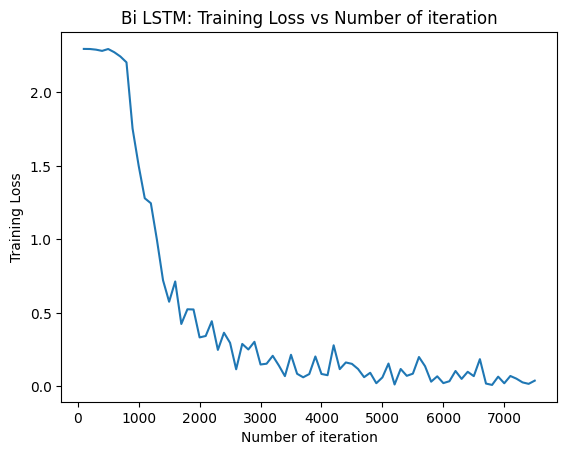

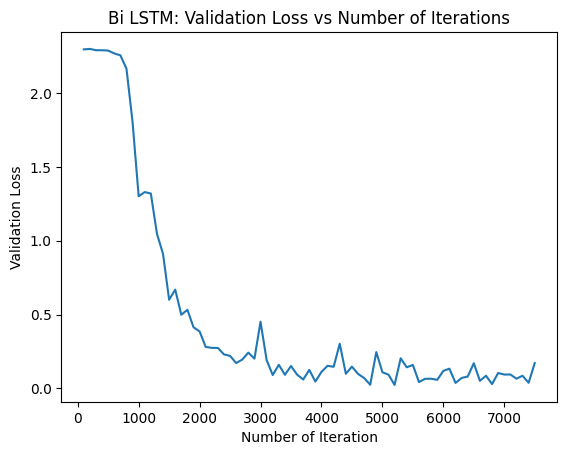

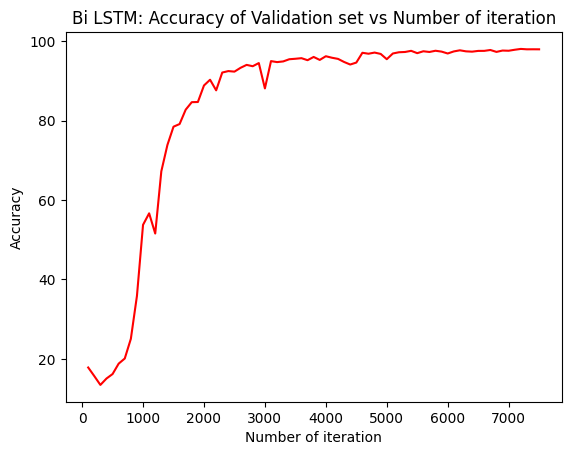

In [211]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Training Loss")
plt.title("Bi LSTM: Training Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list, validation_error)
plt.xlabel("Number of Iteration")
plt.ylabel("Validation Loss")
plt.title("Bi LSTM: Validation Loss vs Number of Iterations")
plt.show()
# visualization accuracy 
plt.plot(iteration_list,accuracy_val,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Bi LSTM: Accuracy of Validation set vs Number of iteration")
plt.savefig('graph.png')
plt.show()

In [212]:
correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader:
    images = Variable(images.view(-1, seq_dim, input_dim))
    
    # Forward propagation
    outputs = model(images)
    temp_loss = error(outputs, labels)
    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]
    
    # Total number of labels
    total += labels.size(0)
    
    correct += (predicted == labels).sum()

accuracy = 100 * correct / float(total)
print("Accuracy on test data using Bidirection LSTM model is",accuracy.item(),"%")

Accuracy on test data using Bidirection LSTM model is 97.79000091552734 %


# 2. Adding Two Binary String

### 2.1 Data Preparation

In [70]:
def find_bit_num(N, size=5):
    if(N>=(2**size)):
        print("Please enter proper inputs")
        return False
    s = []
    for i in range(size):
        v = 2**(size-i-1)
        if(N>=v):
            N = N-v
            s.append(1)
        else:
            s.append(0)
    return s

In [71]:
#testing the above function
find_bit_num(9)

[0, 1, 0, 0, 1]

### 2.2 Model

In [72]:
class LSTM_Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

        out, (hn, cn) = self.lstm(x,(h0, c0))
        out = self.fc(out[:,-1,:])
        return out

### 2.3 Experiments

In [155]:

def measure_accuracy(store):
    '''
    Measures accuracy of prediction of a model.
    '''
    for i in range(len(store)):
        store[i][0][store[i][0]>0.5] = 1
        store[i][0][store[i][0]<=0.5] = 0
    sums = 0
    for i in range(len(store)):
        sums = sums + (torch.sum(store[i][0] == store[i][1]) == 5)
    #print("Accuracy is = ", sums.item()/len(store)*100,"%")
    return sums.item()/len(store)*100

In [185]:
def bit_accuracy(model, n):
    N = 2**n
    x = []
    y = []
    for i in range(N):
        for j in range(N):
            if(i+j<N):
                x.append([i,j])
                y.append(i+j)
    x = np.array(x)
    y = np.array(y)
    train_data = x
    train_labels = y
    sums = 0
    for i in range(x.shape[0]):
        temp_x = np.array(find_bit_num(train_data[i][0],n))
        temp_x = np.vstack((temp_x,np.array(find_bit_num(train_data[i][1],n))))
        temp_y = np.array(find_bit_num(train_labels[i],n))
        
        temp_x = torch.tensor(temp_x.T, dtype=torch.float32).view(1,n,2)
        temp_y = torch.tensor(temp_y.T, dtype=torch.float32).view(1,n)
        #print(temp_x, temp_y)
        outputs = model(temp_x)
        outputs[outputs>=0.5] = 1
        outputs[outputs<0.5] = 0
        sums = sums + (torch.sum(outputs==temp_y)==5)
    sums = sums.item()
    acc = sums/x.shape[0]*100.0
    return acc

#### String length L = 3

In [220]:
def train_binary_string_rnn(L, hidden_dim, loss = "cse", show_print = False):
    n = L
    input_dim = 2
    output_dim = n
    num_layer = 1
    model = LSTM_Model(input_dim, hidden_dim, num_layer, output_dim)

    learning_rate = 0.01
    optimization = torch.optim.Adam(model.parameters(), lr = learning_rate)
    if(loss=="cse"):
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.MSELoss()


    N = 2**n
    x = []
    y = []
    for i in range(N):
        for j in range(N):
            if(i+j<N):
                x.append([i,j])
                y.append(i+j)
    x = np.array(x)
    y = np.array(y)
    num_training_examples = int(0.80*len(x))
    train_indexes = np.random.randint(0,len(x),num_training_examples)
    #training
    train_data = x[train_indexes]
    train_labels = y[train_indexes]
    epochs = 20
    iter = 0
    plot_accuracy = []
    l = []
    store = []
    training_loss = []
    count = 0
    while(iter<epochs):
        iter = iter + 1
        store = []
        for i in range(train_labels.shape[0]):
            count = count + 1
            temp_x = np.array(find_bit_num(train_data[i][0],n))
            temp_x = np.vstack((temp_x,np.array(find_bit_num(train_data[i][1],n))))
            temp_y = np.array(find_bit_num(train_labels[i],n))
            
            temp_x = torch.tensor(temp_x.T, dtype=torch.float32).view(1,n,2)
            temp_y = torch.tensor(temp_y.T, dtype=torch.float32).view(1,n)
            #print(temp_x, temp_y)
            
            outputs = model(temp_x)
            optimization.zero_grad()
            outputs = model(temp_x)
            loss = criterion(outputs, temp_y)
            store.append([outputs, temp_y])
            loss.backward()
            optimization.step()
            if(count%500==0):
                print("ok")
                training_loss.append(loss.item())
        print("wtf")
        plot_accuracy.append(measure_accuracy(store))
        if(show_print == True):
            print("Epoch Number: ",iter)
    print("The bit accuracy of this model is ", bit_accuracy(model, n),"%")

    plt.plot(plot_accuracy)
    plt.title("Training Accuracy vs Number of Iterations")
    plt.xlabel("Number of Iterations")
    plt.show()

    plt.plot(training_loss)
    plt.title("Training Loss vs Number of Iterations")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Train Loss")
    plt.show()

    return model



Vary the state vector size and check if there is any improvement in bit-accuracy.

Hidden cell dimension =  5
The bit accuracy of this model is  63.4469696969697 %


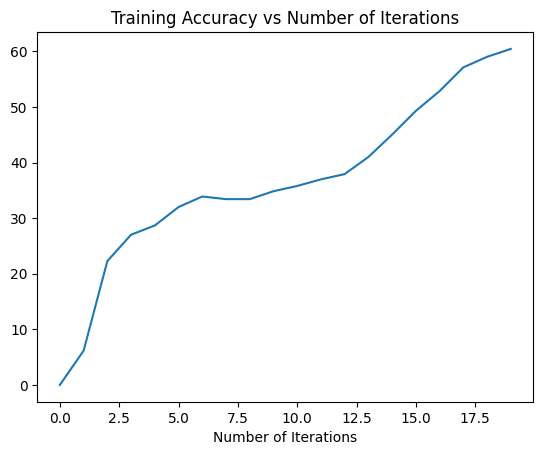

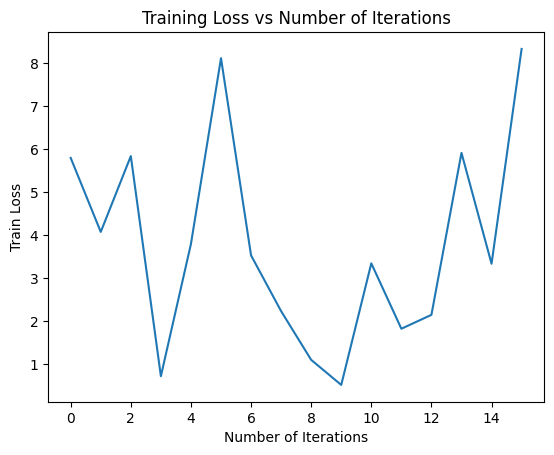

Hidden cell dimension =  10
The bit accuracy of this model is  86.93181818181817 %


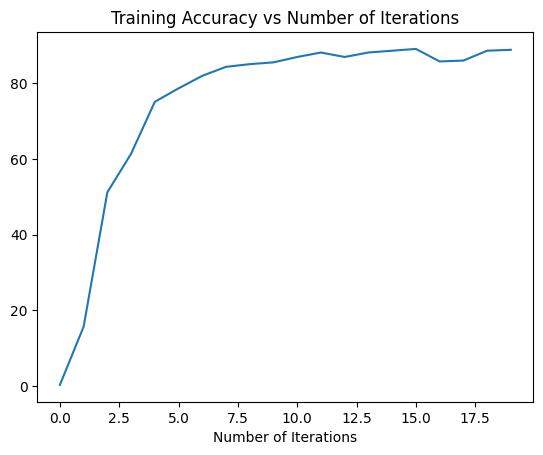

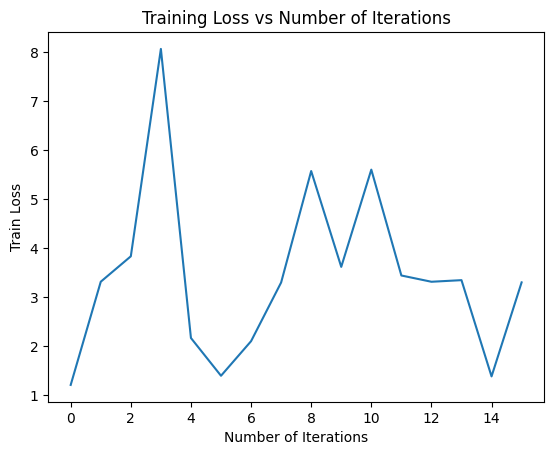

Hidden cell dimension =  15
The bit accuracy of this model is  87.87878787878788 %


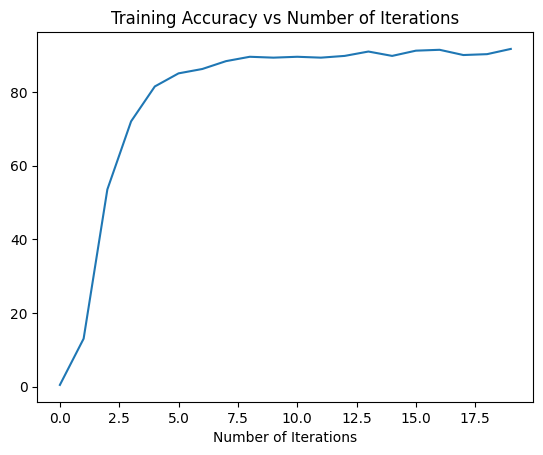

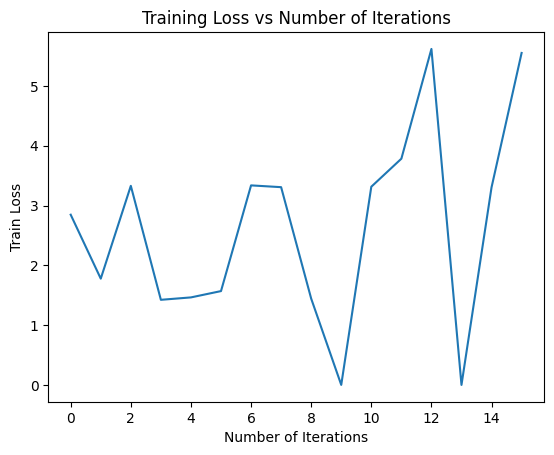

In [190]:
# if input size is n
L = 5

#hidden layer size = n
print("Hidden cell dimension = ", L)
model_5 = train_binary_string_rnn(L, hidden_dim=L)

#hidden layer size = n
print("Hidden cell dimension = ", 2*L)
model_5 = train_binary_string_rnn(L, hidden_dim=2*L)

#hidden layer size = n
print("Hidden cell dimension = ", 3*L)
model_5 = train_binary_string_rnn(L, hidden_dim=3*L)

Comments on the change of hidden layer dimension.<br>
- As we can see from above plots higher the hidden cell dimension higher is the accuracy<br>
- Hidden cell dimension is directly proportional to accuracy

  .
  

##### Cross Entropy Loss vs MSE

Cross Entropy Loss criterion
The bit accuracy of this model is  88.82575757575758 %


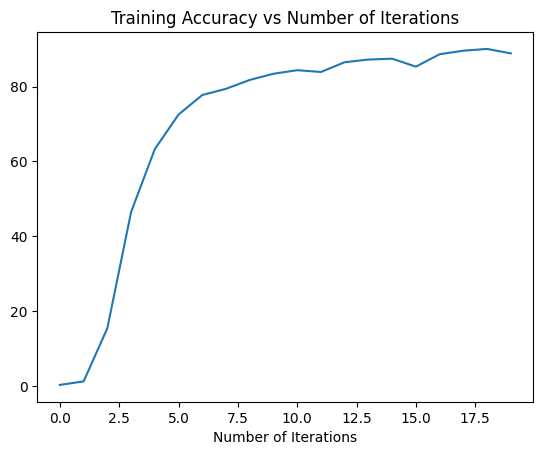

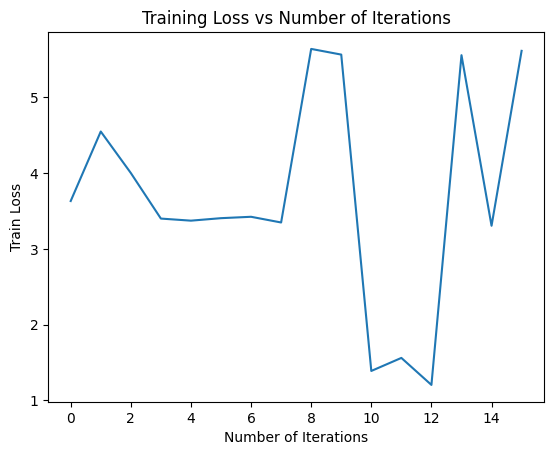

In [192]:
#Cross entropy losss
print("Cross Entropy Loss criterion")
model_5 = train_binary_string_rnn(L, hidden_dim=2*L, loss="cse")

Mean square error Loss criterion
The bit accuracy of this model is  99.43181818181817 %


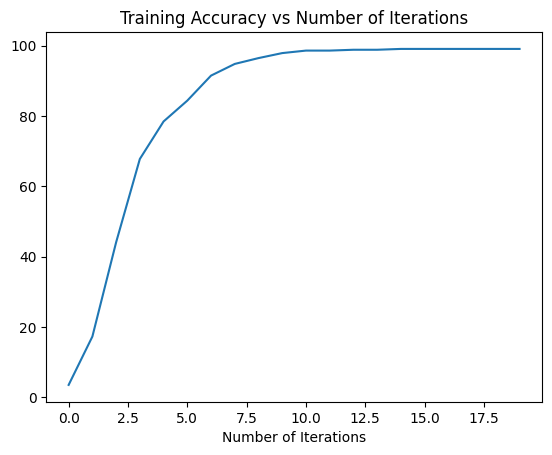

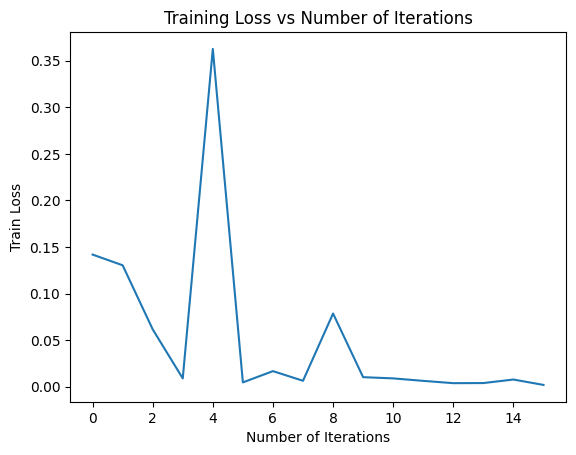

In [193]:
#Mean Square error loss
print("Mean square error Loss criterion")
model_5 = train_binary_string_rnn(L, hidden_dim=2*L, loss="MSE")

Comments on the choice of loss function<br>
- for above experiments I have used same hyperparameters the only difference is loss function.
- for Cross entropy loss the accuracy for 20 ephocs is 88% whereas for Mean square error loss the accuracy is 99%.
- MSE loss works way better than CSE loss.

.


#### For fixed length string lengths

Length of string is 3
The bit accuracy of this model is  0.0 %


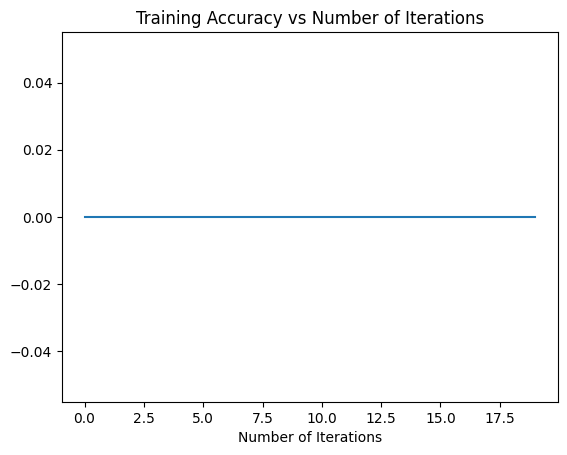

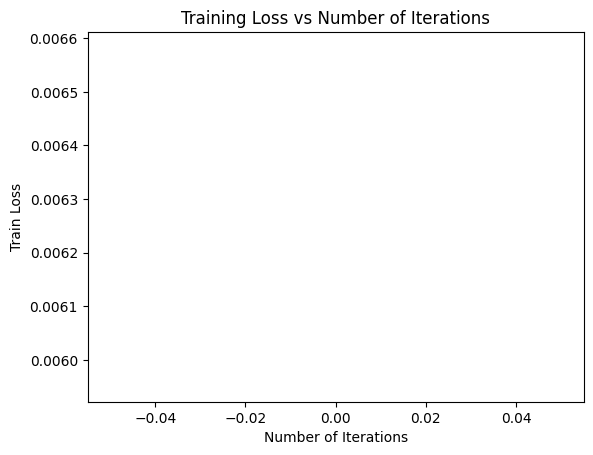

In [215]:
#L = 3
L = 3
print("Length of string is", L )
model_3 = train_binary_string_rnn(L, hidden_dim=2*L, loss="MSE")

Length of string is 5
The bit accuracy of this model is  94.31818181818183 %


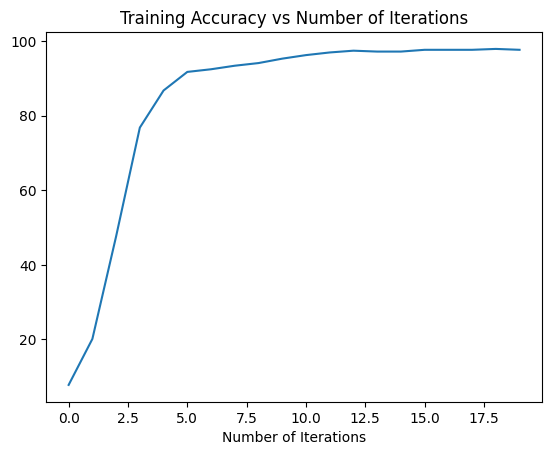

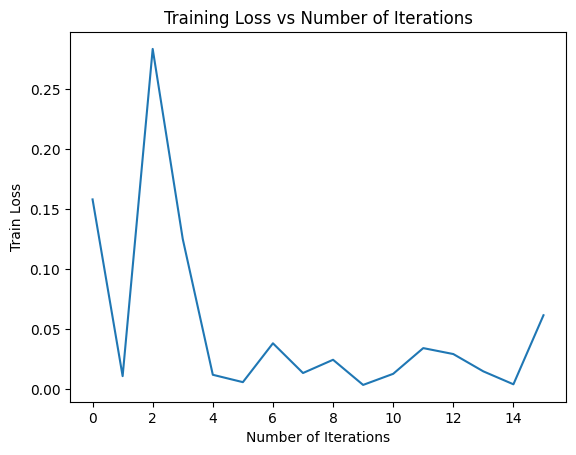

In [214]:
#L = 5
L = 5
print("Length of string is", L )
model_5 = train_binary_string_rnn(L, hidden_dim=2*L, loss="MSE")

In [217]:
#L = 10
L = 10
print("Length of string is", L )
model_10 = train_binary_string_rnn(L, hidden_dim=L+2, loss="MSE", show_print=True)

Length of string is 10


KeyboardInterrupt: 